## Deep learning methods

In [1]:
import tensorflow as tf
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Loading the data

In [2]:
preprocessed_df = joblib.load("preprocessed_df.pkl")
label_names = preprocessed_df.columns[3:-1]
y_train = joblib.load('y_train.pkl')
y_test = joblib.load("y_test.pkl")
embeddings_train = joblib.load("sequences_train.pkl")
embeddings_tests = joblib.load("sequences_test.pkl")
tfidf_train = joblib.load("tfidf_train.pkl")
tfidf_test = joblib.load("tfidf_test.pkl")
sense_train = joblib.load("sense_vectors_train.pkl")
sense_test = joblib.load("sense_vectors_test.pkl")
print(label_names)
print(y_train.shape)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
(20972, 35)


### Deep models

Small LSTM model for embeddings and small dense model for TF-IDF features

In [3]:
def dense_model(input_shape, output_dim, dense_dim):
    inp = tf.keras.Input(input_shape[1:])
    x = tf.keras.layers.Dense(dense_dim, activation="relu")(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
    return tf.keras.Model(inputs = inp, outputs = output)

def lstm_model(input_shape, output_dim, lstm_dim: int = 256, embedding_dim: int = None, vocabulary: int = 5000):
    inp = tf.keras.layers.Input(input_shape[1:])
    x = inp
    if embedding_dim:
        x = tf.keras.layers.Embedding(vocabulary, embedding_dim, mask_zero=True)(x)
    else:
        x = tf.keras.layers.Masking()(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=False), merge_mode="sum")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(lstm_dim//2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
    return tf.keras.Model(inputs = inp, outputs = output)

model_dense = dense_model(input_shape=tfidf_train.shape, output_dim=y_train.shape[1], dense_dim=128)
model_lstm = lstm_model(embeddings_train.shape, output_dim=y_train.shape[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6224)]            0         
                                                                 
 dense (Dense)               (None, 128)               796800    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                4515      
                                                                 
Total params: 801,315
Trainable params: 801,315
Non-trainable params: 0
_________________________________________________________________


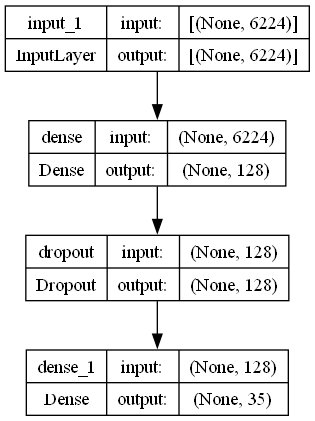

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100)]        0         
                                                                 
 masking (Masking)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              731136    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

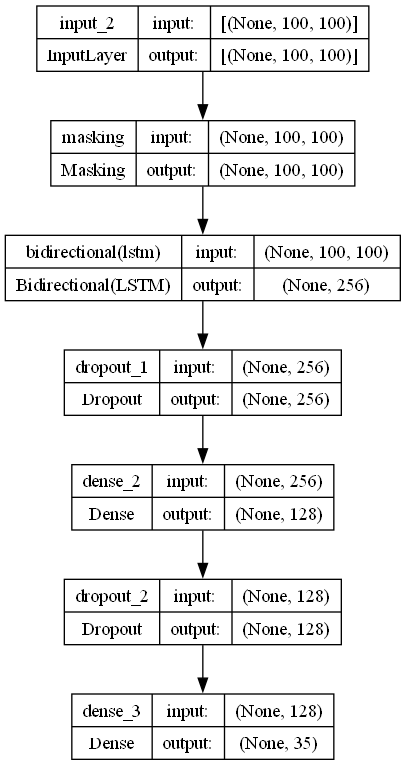

In [4]:
model_dense.summary()
display(tf.keras.utils.plot_model(model_dense, show_shapes=True))
model_lstm.summary()
display(tf.keras.utils.plot_model(model_lstm, show_shapes=True))

### TF-IDF vectors on dense model

In [5]:
tfidf_train_tensors = tf.data.Dataset.from_tensor_slices((tfidf_train.toarray(), y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
tfidf_test_tensors = tf.data.Dataset.from_tensor_slices((tfidf_test.toarray(), y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [6]:
model_dense.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_dense.fit(tfidf_train_tensors, validation_data = tfidf_test_tensors, epochs = 5)

Epoch 1/5
1311/1311 [==============================] - 13s 9ms/step - loss: 0.2166 - auc: 0.6751 - val_loss: 0.1675 - val_auc: 0.7997
Epoch 2/5
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1492 - auc: 0.8490 - val_loss: 0.1529 - val_auc: 0.8329
Epoch 3/5
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1294 - auc: 0.8961 - val_loss: 0.1498 - val_auc: 0.8421
Epoch 4/5
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1162 - auc: 0.9233 - val_loss: 0.1511 - val_auc: 0.8393
Epoch 5/5
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1060 - auc: 0.9414 - val_loss: 0.1546 - val_auc: 0.8358


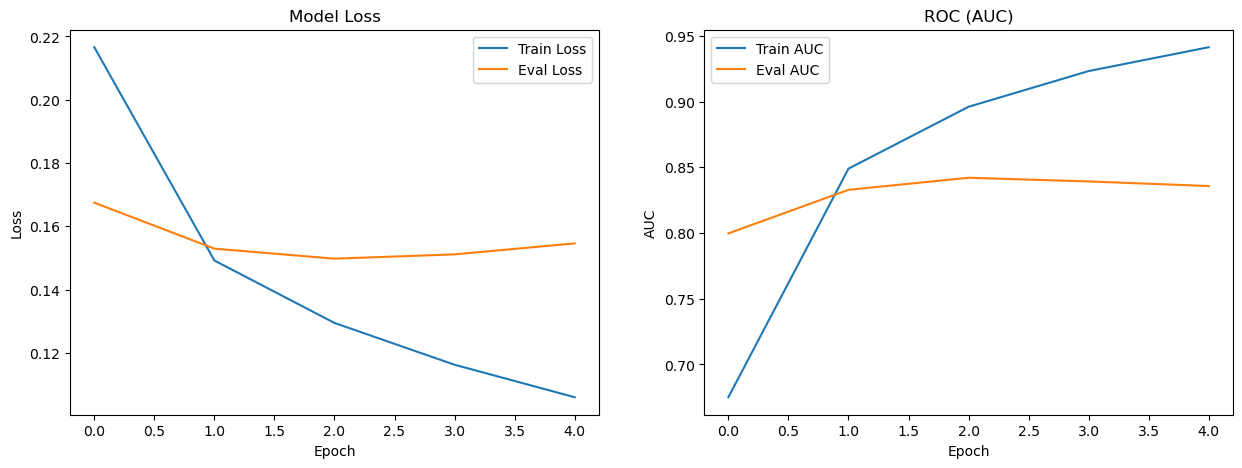

                        precision    recall  f1-score   support

               related       0.87      0.91      0.89      4018
               request       0.74      0.63      0.68       911
                 offer        nan      0.00      0.00        21
           aid_related       0.75      0.71      0.73      2232
          medical_help       0.58      0.30      0.40       438
      medical_products       0.68      0.28      0.40       265
     search_and_rescue       0.77      0.13      0.22       152
              security       0.50      0.01      0.02        82
              military       0.70      0.41      0.52       166
                 water       0.76      0.53      0.63       345
                  food       0.82      0.71      0.76       607
               shelter       0.72      0.52      0.60       465
              clothing       0.55      0.26      0.35        82
                 money       0.70      0.17      0.28       120
        missing_people       0.83      

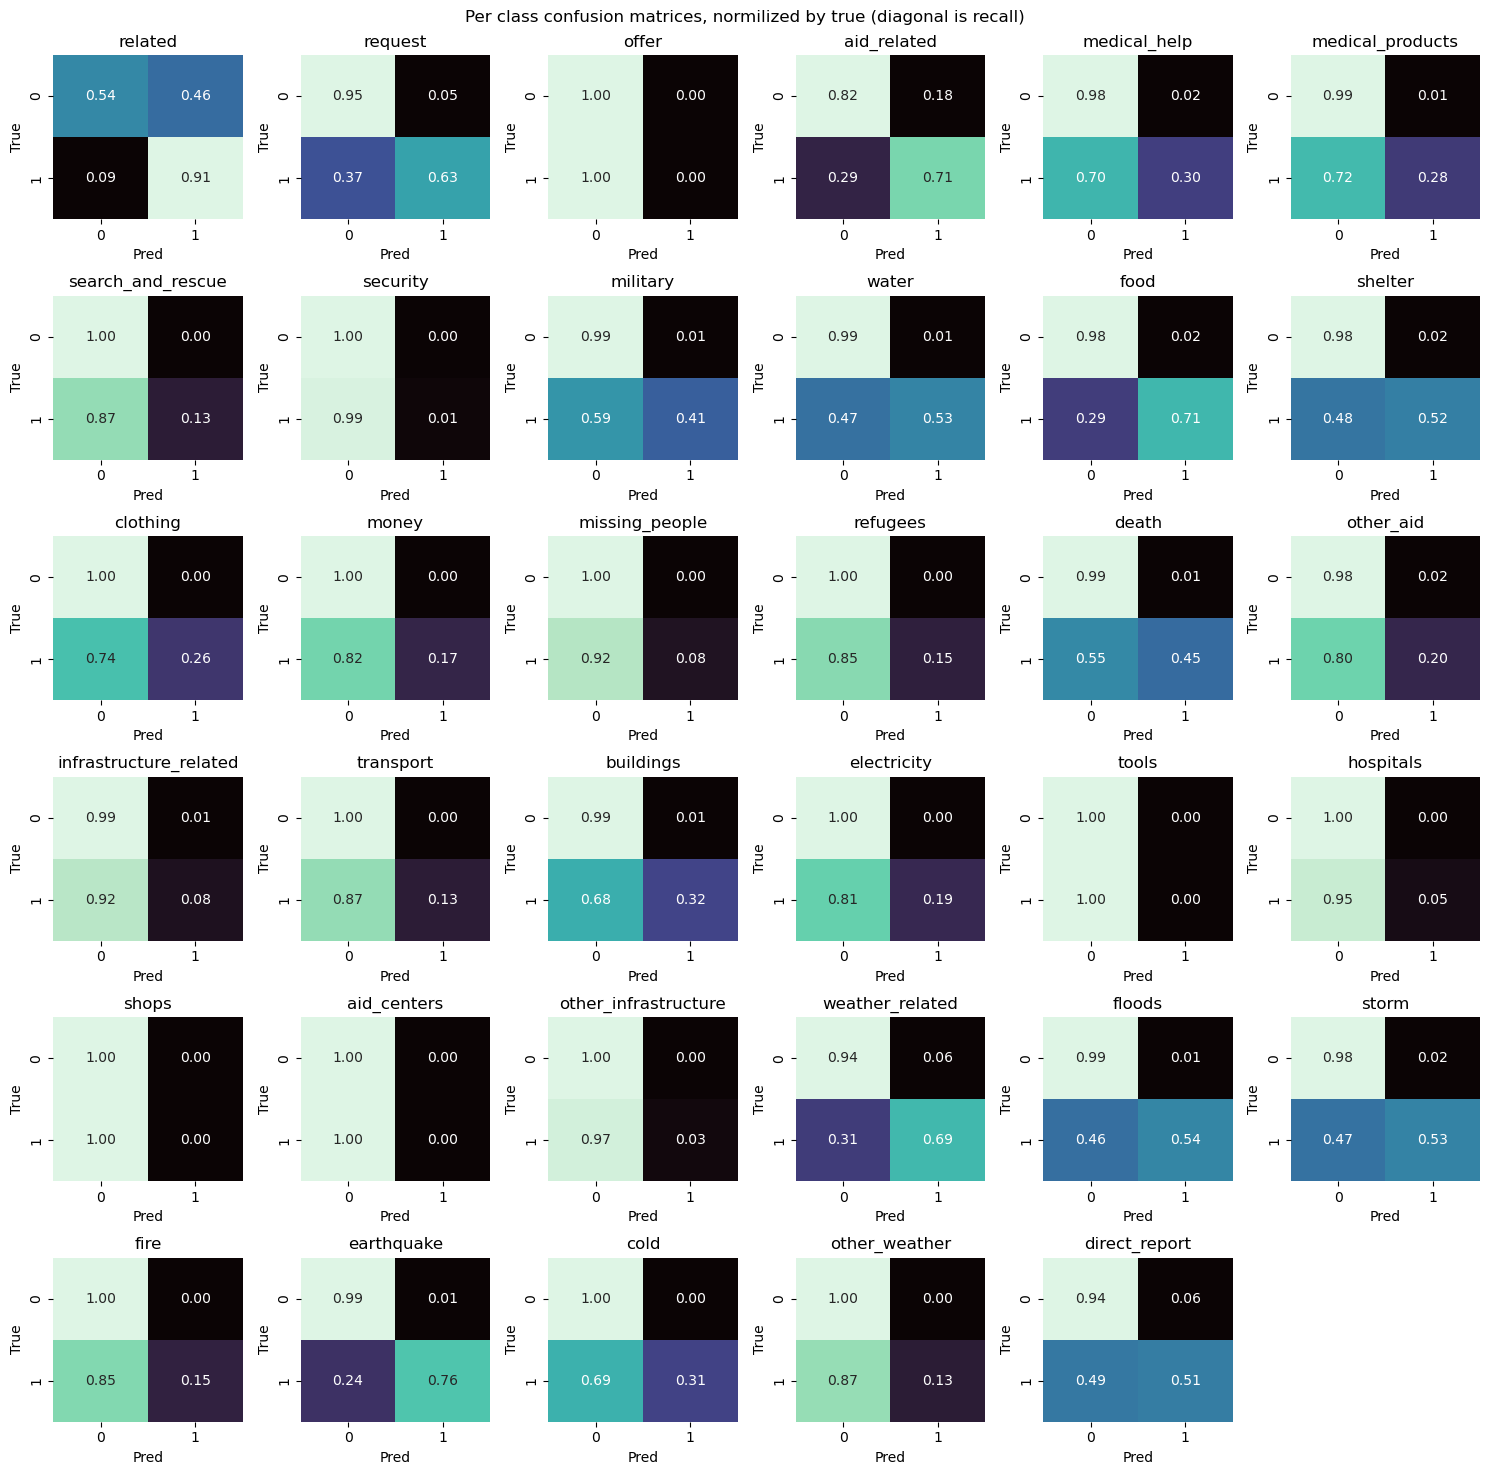

In [7]:
def results(history, epochs, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    auc = history.history[f'auc{prefix}']
    val_auc =  history.history[f'val_auc{prefix}']

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(epochs)
        plt.subplot(1, 2, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(auc, val_auc, "AUC", 2, "ROC (AUC)")
    plt.show()

results(history, 5,  "")
def eval_model(test_x, test_y, labels, model,):
    preds = model.predict(test_x, verbose = 0)
    preds = (preds > 0.5).astype(np.int32).squeeze()
    cr = classification_report(test_y, preds, target_names = labels, zero_division=np.nan)
    print(cr)
    def plot_cms(y_test, preds, labels):
        plt.figure(figsize=(15,15))
        for i in range(len(labels)):
            plt.subplot(6,6,i+1)
            plt.title(f"{labels[i]}")
            cm = confusion_matrix(y_test[:, i], preds[:, i], normalize = "true")
            sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, cmap="mako")
            plt.ylabel("True")
            plt.xlabel("Pred")
        plt.tight_layout()
        plt.suptitle("Per class confusion matrices, normilized by true (diagonal is recall)")
        plt.subplots_adjust(top=0.95)
        plt.show()
    plot_cms(test_y, preds, labels)

eval_model(tfidf_test.toarray(), y_test, label_names, model_dense)

### Sense embeddings

In [8]:
sense_train_tensors = tf.data.Dataset.from_tensor_slices((sense_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
sense_test_tensors = tf.data.Dataset.from_tensor_slices((sense_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [9]:
model_dense = dense_model(input_shape=sense_train.shape, output_dim=y_train.shape[1], dense_dim=256)
model_dense.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_dense.fit(sense_train_tensors , validation_data = sense_test_tensors, epochs = 10)

Epoch 1/10
1311/1311 [==============================] - 12s 8ms/step - loss: 0.1942 - auc_1: 0.7273 - val_loss: 0.1739 - val_auc_1: 0.7959
Epoch 2/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1689 - auc_1: 0.7988 - val_loss: 0.1682 - val_auc_1: 0.8160
Epoch 3/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1651 - auc_1: 0.8118 - val_loss: 0.1659 - val_auc_1: 0.8196
Epoch 4/10
1311/1311 [==============================] - 9s 7ms/step - loss: 0.1630 - auc_1: 0.8180 - val_loss: 0.1646 - val_auc_1: 0.8224
Epoch 5/10
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1614 - auc_1: 0.8218 - val_loss: 0.1636 - val_auc_1: 0.8230
Epoch 6/10
1311/1311 [==============================] - 10s 8ms/step - loss: 0.1604 - auc_1: 0.8246 - val_loss: 0.1628 - val_auc_1: 0.8251
Epoch 7/10
1311/1311 [==============================] - 11s 8ms/step - loss: 0.1595 - auc_1: 0.8269 - val_loss: 0.1622 - val_auc_1: 0.8272
Epoch 8/10
1311/1311 [========

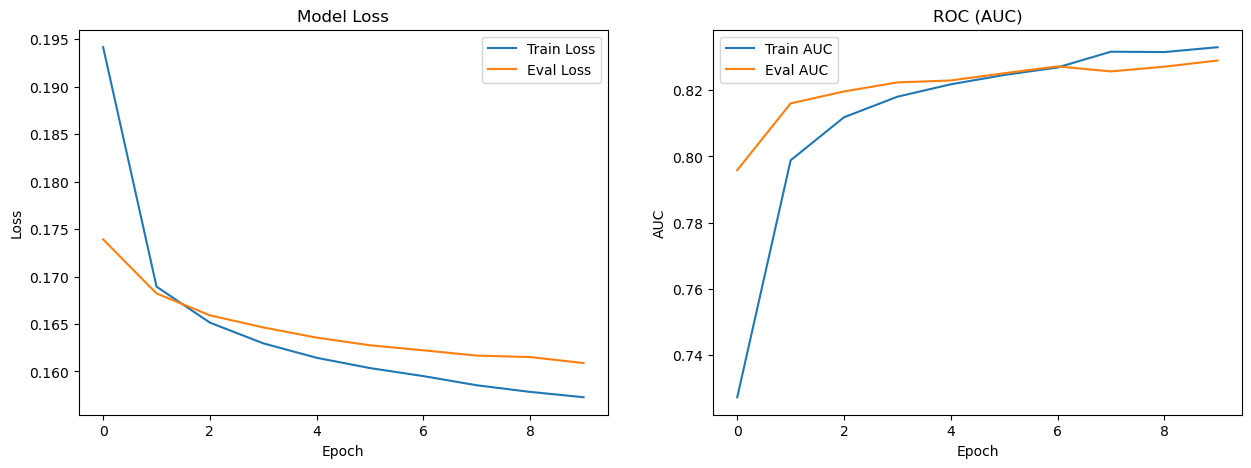

                        precision    recall  f1-score   support

               related       0.83      0.96      0.89      4018
               request       0.72      0.63      0.67       911
                 offer        nan      0.00      0.00        21
           aid_related       0.69      0.74      0.72      2232
          medical_help       0.54      0.20      0.29       438
      medical_products       0.56      0.11      0.18       265
     search_and_rescue        nan      0.00      0.00       152
              security        nan      0.00      0.00        82
              military       0.60      0.15      0.24       166
                 water       0.77      0.47      0.59       345
                  food       0.76      0.59      0.66       607
               shelter       0.76      0.36      0.49       465
              clothing       0.57      0.15      0.23        82
                 money       0.67      0.02      0.03       120
        missing_people        nan      

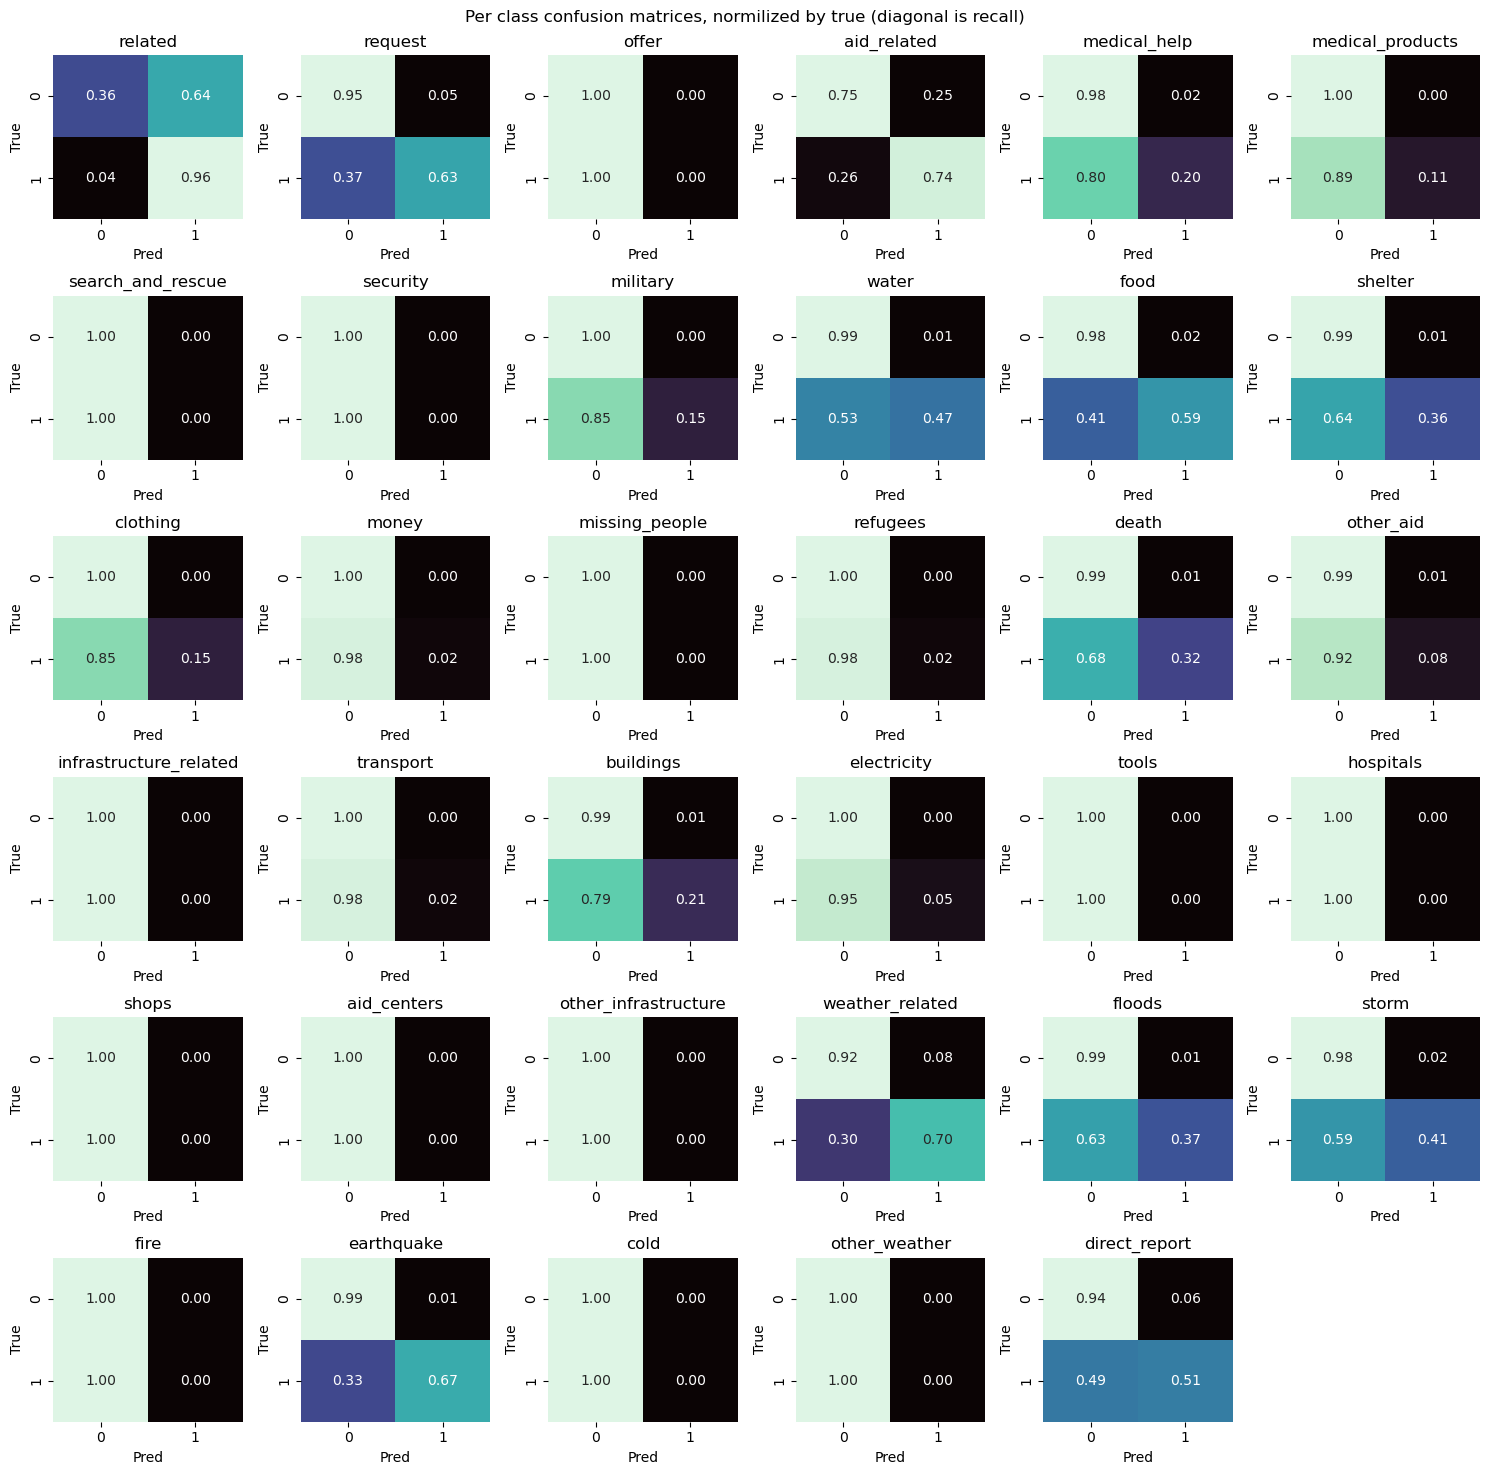

In [10]:
results(history, 10,  "_1")
eval_model(sense_test, y_test, label_names, model_dense)

## LSTM model on word2vec embeddings

In [11]:
embeddings_train_tensors = tf.data.Dataset.from_tensor_slices((embeddings_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
embeddings_test_tensors = tf.data.Dataset.from_tensor_slices((embeddings_tests, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

In [12]:
model_lstm = lstm_model(embeddings_train.shape, output_dim=y_train.shape[1])

In [13]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_lstm.fit(embeddings_train_tensors, validation_data = embeddings_test_tensors , epochs = 10)

Epoch 1/10
1311/1311 [==============================] - 73s 45ms/step - loss: 0.2251 - auc_2: 0.6626 - val_loss: 0.1743 - val_auc_2: 0.7795
Epoch 2/10
1311/1311 [==============================] - 55s 42ms/step - loss: 0.1766 - auc_2: 0.7683 - val_loss: 0.1662 - val_auc_2: 0.8041
Epoch 3/10
1311/1311 [==============================] - 55s 42ms/step - loss: 0.1676 - auc_2: 0.7911 - val_loss: 0.1618 - val_auc_2: 0.8156
Epoch 4/10
1311/1311 [==============================] - 55s 42ms/step - loss: 0.1629 - auc_2: 0.8045 - val_loss: 0.1596 - val_auc_2: 0.8216
Epoch 5/10
1311/1311 [==============================] - 56s 43ms/step - loss: 0.1595 - auc_2: 0.8123 - val_loss: 0.1578 - val_auc_2: 0.8253
Epoch 6/10
1311/1311 [==============================] - 55s 42ms/step - loss: 0.1566 - auc_2: 0.8219 - val_loss: 0.1571 - val_auc_2: 0.8274
Epoch 7/10
1311/1311 [==============================] - 56s 42ms/step - loss: 0.1543 - auc_2: 0.8269 - val_loss: 0.1559 - val_auc_2: 0.8295
Epoch 8/10
1311/1311

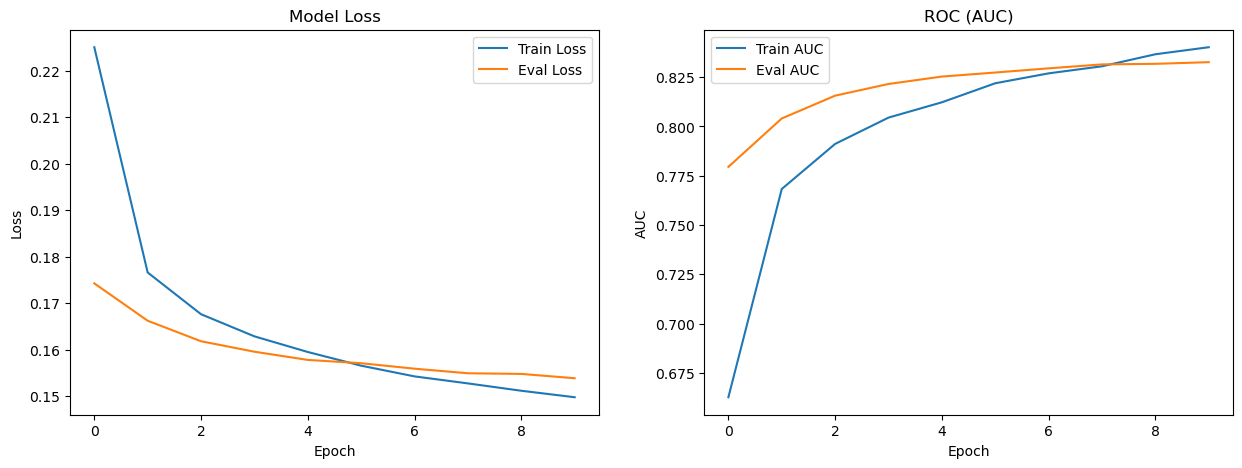

                        precision    recall  f1-score   support

               related       0.85      0.94      0.89      4018
               request       0.74      0.65      0.69       911
                 offer        nan      0.00      0.00        21
           aid_related       0.73      0.73      0.73      2232
          medical_help       0.57      0.24      0.33       438
      medical_products       0.54      0.19      0.28       265
     search_and_rescue       1.00      0.01      0.01       152
              security        nan      0.00      0.00        82
              military       0.59      0.17      0.27       166
                 water       0.81      0.57      0.67       345
                  food       0.79      0.69      0.74       607
               shelter       0.74      0.53      0.61       465
              clothing       0.37      0.12      0.18        82
                 money       0.86      0.05      0.09       120
        missing_people        nan      

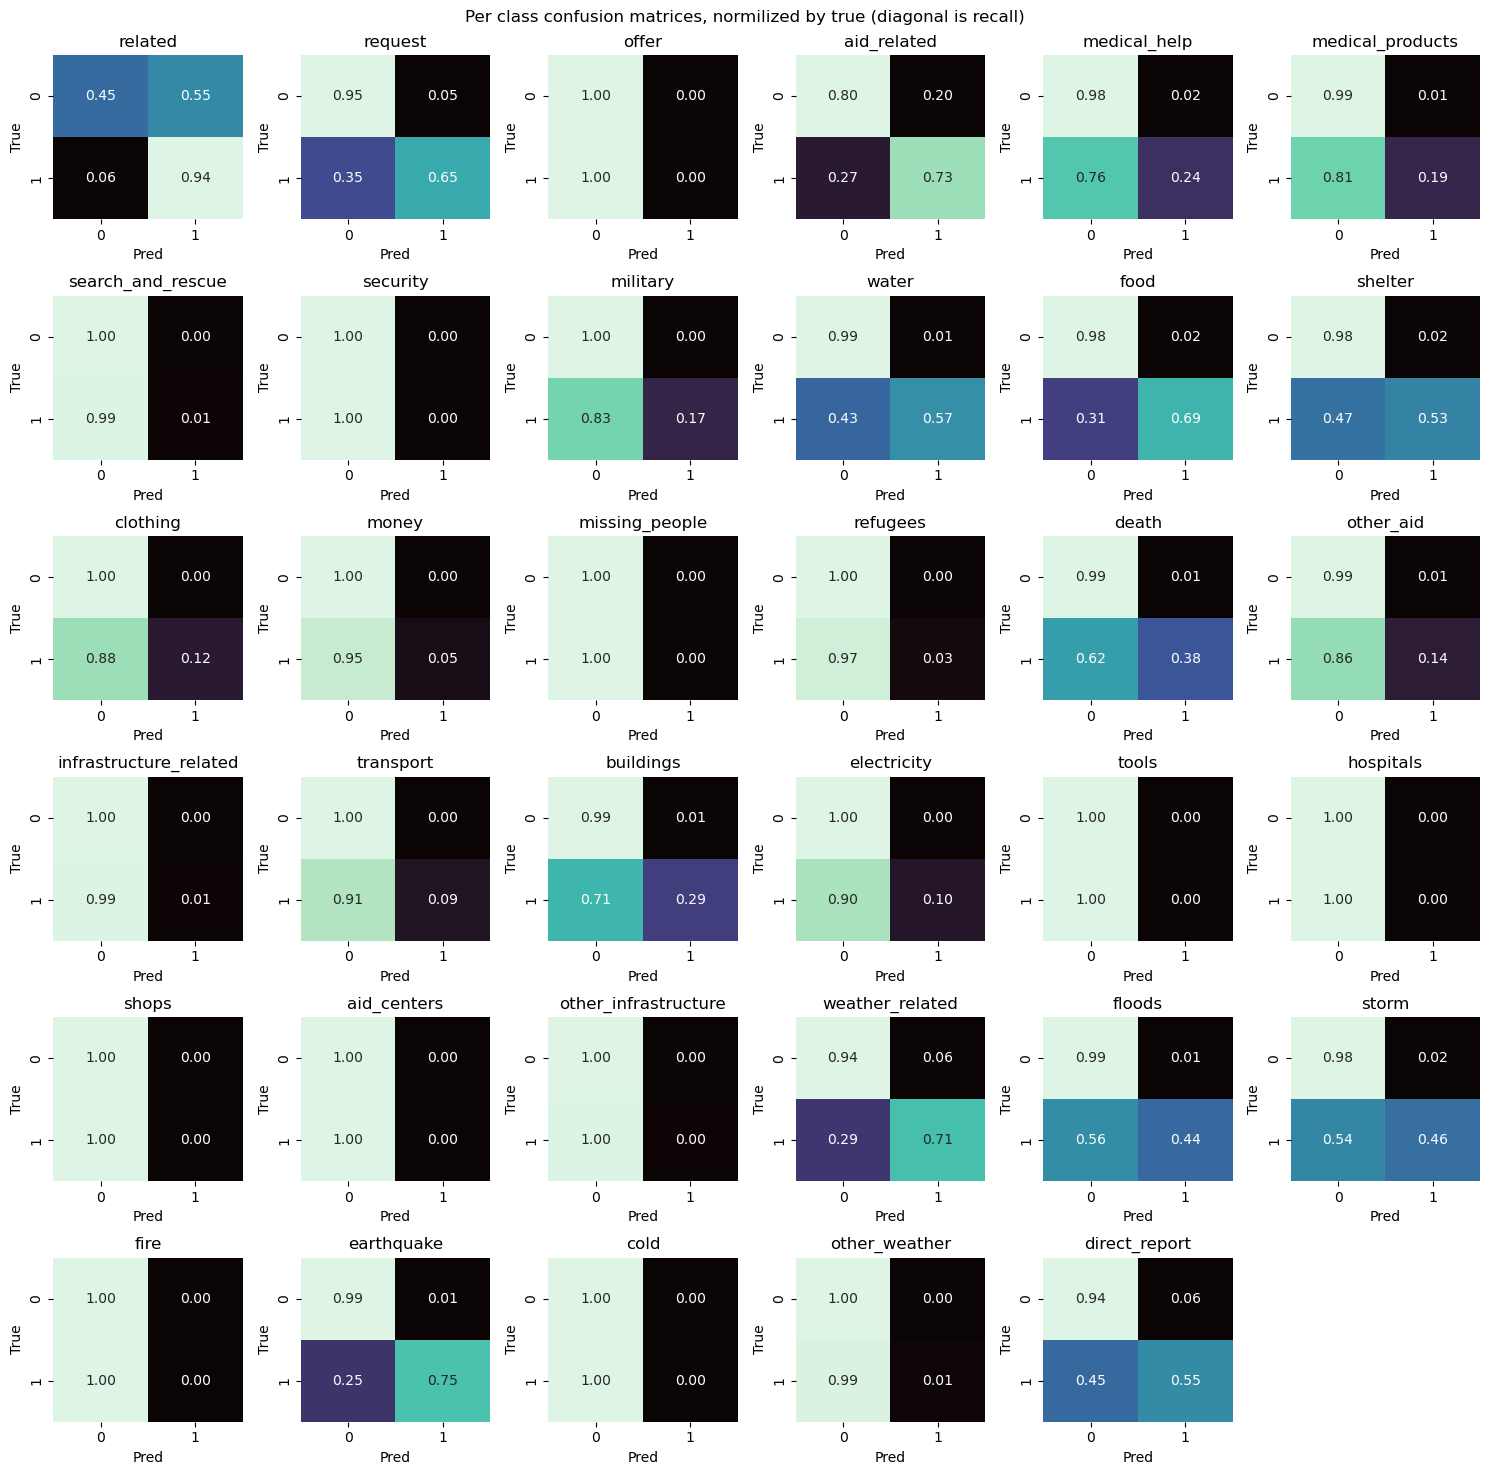

In [15]:
results(history, 10,  "_2")
eval_model(embeddings_tests, y_test, label_names, model_lstm)